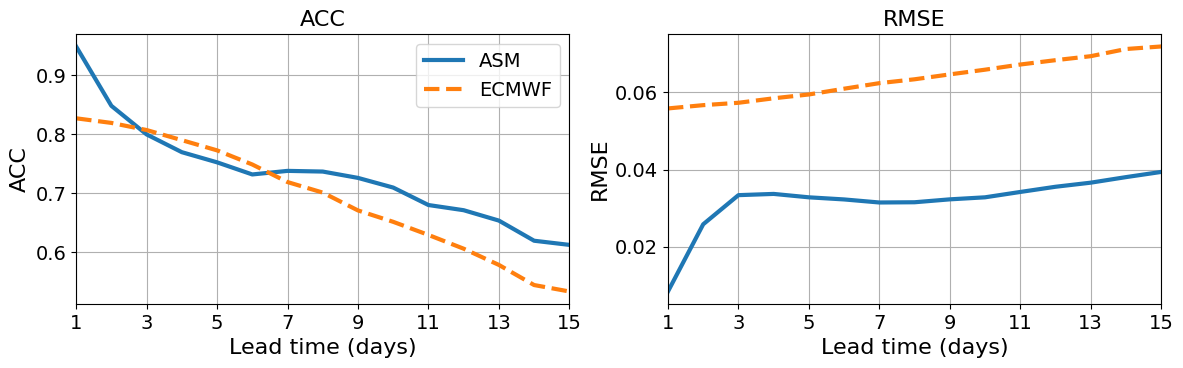

In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs

land_mask = np.load('../../Data/land_mask_1_no_green.npy')

data = np.load('ACC_RMSE.npz')

acc_preds = data['acc_asm']
acc_ecmwf = data['acc_ecmwf']
rmse_preds = data['rmse_asm']
rmse_ecmwf = data['rmse_ecmwf']

ACC_dict = {}
RMSE_dict = {}

ACC_dict['ASM'] = acc_preds
ACC_dict['ECMWF'] = acc_ecmwf
RMSE_dict['ASM'] = rmse_preds
RMSE_dict['ECMWF'] = rmse_ecmwf

names1 = ['ASM', 'ECMWF']

plt.rcParams.update({
    "font.size": 16,         
    "axes.titlesize": 16,    
    "axes.labelsize": 16,  
    "xtick.labelsize": 14,   
    "ytick.labelsize": 14,  
    "legend.fontsize": 14,  
})

N = len(ACC_dict['ASM'])  
x = np.arange(1, N+1)    

fig, axes = plt.subplots(1, 2, figsize=(14, 3.5)) 

ax = axes[0]
lines = []
for name in names1:
    linestyle = '-' if name == 'ASM' else '--'
    line, = ax.plot(x, ACC_dict[name], label=name, linestyle=linestyle, linewidth=3)
    lines.append(line)

ax.set_xlabel('Lead time (days)')
ax.set_ylabel('ACC')
ax.set_title('ACC')
ax.tick_params(axis='both')
ax.grid(True)
ax.legend(loc='upper right', frameon=True, facecolor='white')
ax.set_xlim(1, N)
ax.set_xticks(np.arange(1, N+1, step=2)) 

ax = axes[1]
for i, name in enumerate(names1):
    linestyle = '-' if name == 'ASM' else '--'
    line, = ax.plot(x, RMSE_dict[name], label=name, linestyle=linestyle, linewidth=3)
    lines.append(line)

ax.set_xlabel('Lead time (days)')
ax.set_ylabel('RMSE')
ax.set_title('RMSE')
ax.tick_params(axis='both')
ax.grid(True)
ax.set_xlim(1, N)
ax.set_xticks(np.arange(1, N+1, step=2)) 

plt.savefig('figure_3.png', dpi = 300, bbox_inches='tight')
plt.show()

In [2]:
spatial_list = np.load('spatial_distribution.npz')

lon_vals = np.linspace(0, 360, 360)
lat = np.linspace(90, -90, 181)
lon_vals_shifted = (lon_vals + 180) % 360 - 180
sorted_indices = np.argsort(lon_vals_shifted)
lon_vals_new = lon_vals_shifted[sorted_indices]
land_mask_1_sorted = land_mask[:, sorted_indices]

land_mask_bool = land_mask.astype(bool)

spatial_ecmwf_land = spatial_list['spatial_ecmwf'][land_mask_bool]

spatial_swvl2_land = spatial_list['spatial_swvl2'][land_mask_bool]
spatial_preds_land = spatial_list['spatial_preds'][land_mask_bool]

def compute_rmse(pred, obs):
    diff = pred - obs
    rmse = np.sqrt(np.mean(diff**2))
    return rmse

rmse_ecmwf = compute_rmse(spatial_ecmwf_land, spatial_swvl2_land)
rmse_preds = compute_rmse(spatial_preds_land, spatial_swvl2_land)

print(f"RMSE(ECMWF vs SWVL2): {rmse_ecmwf:.4f}")
print(f"RMSE(Pred vs SWVL2): {rmse_preds:.4f}")


RMSE(ECMWF vs SWVL2): 0.0850
RMSE(Pred vs SWVL2): 0.0328


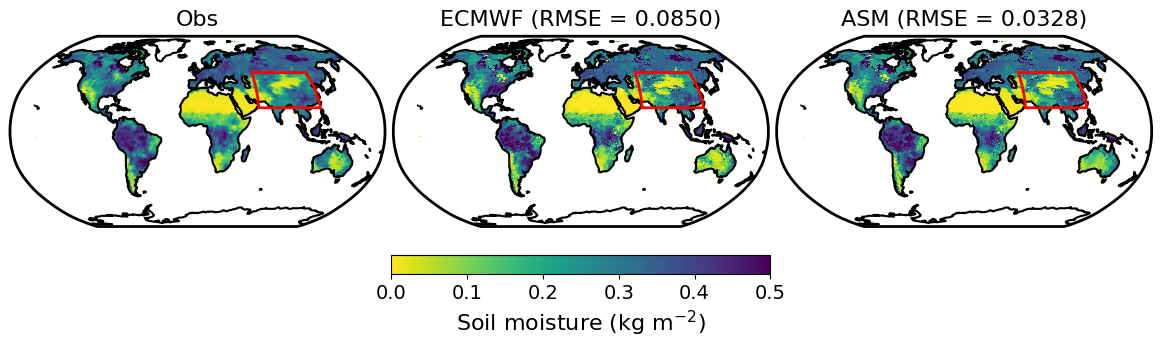

In [3]:
names = ['Obs', 'ECMWF (RMSE = 0.0850)', 'ASM (RMSE = 0.0328)']
names2 = ['spatial_ecmwf', 'spatial_swvl2', 'spatial_preds']
plt.rcParams.update({
    "font.size": 16,          
    "axes.titlesize": 16,   
    "axes.labelsize": 16,    
    "xtick.labelsize": 14,  
    "ytick.labelsize": 14,    
    "legend.fontsize": 14, 
})

lon_min, lon_max = 60, 120
lat_min, lat_max = 20, 50

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11.5, 5),
                         subplot_kw={'projection': ccrs.Robinson()},
                         constrained_layout=True)

for j, var1 in enumerate(names):
    ax = axes[j]

    sim1 = spatial_list[f'{names2[j]}']

    data_sorted = sim1[:, sorted_indices]
    data_masked = np.where(land_mask_1_sorted, data_sorted, np.nan)

    ax.set_extent([-179.9, 179.9, -90, 90], crs=ccrs.PlateCarree())
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)  

    mesh = ax.pcolormesh(
        lon_vals, lat, data_masked,
        transform=ccrs.PlateCarree(),
        cmap = 'viridis_r',
        shading='auto',
        vmin=0, 
        vmax=0.5
    )

    ax.coastlines(linewidth=1.5)

    rect = Rectangle(
    (lon_min, lat_min),
    lon_max - lon_min,
    lat_max - lat_min,
    linewidth=2.0,
    edgecolor='red',
    facecolor='none',
    transform=ccrs.PlateCarree(),
    zorder=10
    )
    ax.add_patch(rect)

    ax.set_title(var1, pad=8)

cbar = fig.colorbar(
    mesh,
    ax=axes,              
    orientation='horizontal',
    fraction=0.05,      
    pad=0.07              
)
cbar.set_label(r"Soil moisture (kg m$^{-2}$)")
plt.savefig('spatial_global.png', dpi=300, bbox_inches='tight')

plt.show()

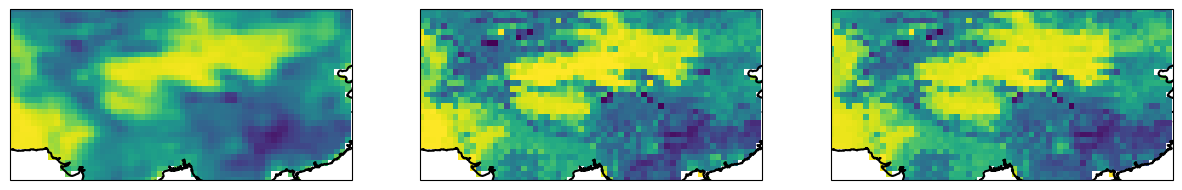

In [4]:
names = ['Obs', 'ECMWF (RMSE = 0.0850)', 'ASM (RMSE = 0.0328)']

plt.rcParams.update({
    "font.size": 16, 
    "axes.titlesize": 16, 
    "axes.labelsize": 16,    
    "xtick.labelsize": 14,  
    "ytick.labelsize": 14,   
    "legend.fontsize": 14,  
})

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()}
                         )

lat_min, lat_max = 20, 50
lon_min, lon_max = 60, 120

lat_mask = (lat >= lat_min) & (lat <= lat_max)
lon_mask = (lon_vals >= lon_min) & (lon_vals <= lon_max)

lat_region = lat[lat_mask]
lon_region = lon_vals[lon_mask]

for j, var1 in enumerate(names):
    ax = axes[j]

    sim1 = spatial_list[f'{names2[j]}']

    data_sorted = sim1[:, sorted_indices]
    data_masked = np.where(land_mask_1_sorted, data_sorted, np.nan)

    data_region = data_masked[np.ix_(lat_mask, lon_mask)]

    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    mesh = ax.pcolormesh(
        lon_region, lat_region, data_region,
        transform=ccrs.PlateCarree(),
        cmap='viridis_r',
        shading='auto',
        vmin=0,
        vmax=0.5
    )

    ax.coastlines(linewidth=1.5)

plt.savefig('spatial_region.png', dpi=300, bbox_inches='tight')

plt.show()